# Probabilistic solvers as collocation methods

Probabilistic solvers condition a prior distribution on satisfying a zero-ODE-residual on a specified grid.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import controls, ivpsolve, timestep
from probdiffeq.impl import impl
from probdiffeq.util.doc_util import notebook
from probdiffeq.solvers import calibrated, uncalibrated, solution, markov
from probdiffeq.solvers.taylor import autodiff
from probdiffeq.solvers.strategies import (
    filters,
    smoothers,
    fixedpoint,
    priors,
    correction,
)

/home/kraemer/Projects/probdiffeq-project/probdiffeq/probdiffeq/ivpsolve.py:15: UserWarning: TODO: make adaptive_solver and initial_condition arguments to the solver! Then, fix the notebooks for good, and merge into main ASAP
  warnings.warn(


In [2]:
from tueplots import bundles

plt.rcParams.update(notebook.plot_config())
plt.rcParams.update(bundles.neurips2022(nrows=3, ncols=3, family="sans-serif"))

In [3]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)

# Make a solver
impl.select("dense", ode_shape=(1,))

In [4]:
# f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vector_field(y, t):
    return 10.0 * y * (2.0 - y)


t0, t1 = 0.0, 0.5
u0 = jnp.asarray([0.1])

In [5]:
NUM_DERIVATIVES = 2
ts = jnp.linspace(t0, t1, num=500, endpoint=True)
init_raw, transitions = priors.ibm_discretised(
    ts, num_derivatives=NUM_DERIVATIVES, output_scale=100.0
)

markov_seq_prior = markov.MarkovSeq(init_raw, transitions)


tcoeffs = autodiff.taylor_mode(
    lambda y: vector_field(y, t=t0), (u0,), num=NUM_DERIVATIVES
)
init_tcoeffs = impl.ssm_util.normal_from_tcoeffs(
    tcoeffs, num_derivatives=NUM_DERIVATIVES
)
markov_seq_tcoeffs = markov.MarkovSeq(init_tcoeffs, transitions)

In [6]:
slr1 = correction.ts1()
ibm = priors.ibm_adaptive(num_derivatives=NUM_DERIVATIVES)
solver = uncalibrated.solver(fixedpoint.fixedpoint_adaptive(ibm, slr1))
dt0 = timestep.propose(lambda y: vector_field(y, t=t0), (u0,))
sol = ivpsolve.solve_and_save_at(
    vector_field,
    tcoeffs,
    save_at=ts,
    rtol=1e-1,
    atol=1e-2,
    dt0=1.0,
    output_scale=1.0,
    solver=solver,
)
# posterior = solution.calibrate(sol.posterior, sol.output_scale)
markov_seq_posterior = markov.select_terminal(sol.posterior)

In [7]:
margs_prior = markov.marginals(markov_seq_prior, reverse=False)
margs_tcoeffs = markov.marginals(markov_seq_tcoeffs, reverse=False)
margs_posterior = markov.marginals(markov_seq_posterior, reverse=True)

In [8]:
num_samples = 5
key = jax.random.PRNGKey(seed=2)
(_qoi, samples_prior), _ = markov.sample(
    key, markov_seq_prior, shape=(num_samples,), reverse=False
)
(_qoi, samples_tcoeffs), _ = markov.sample(
    key, markov_seq_tcoeffs, shape=(num_samples,), reverse=False
)
(_qoi, samples_posterior), _ = markov.sample(
    key, markov_seq_posterior, shape=(num_samples,), reverse=True
)

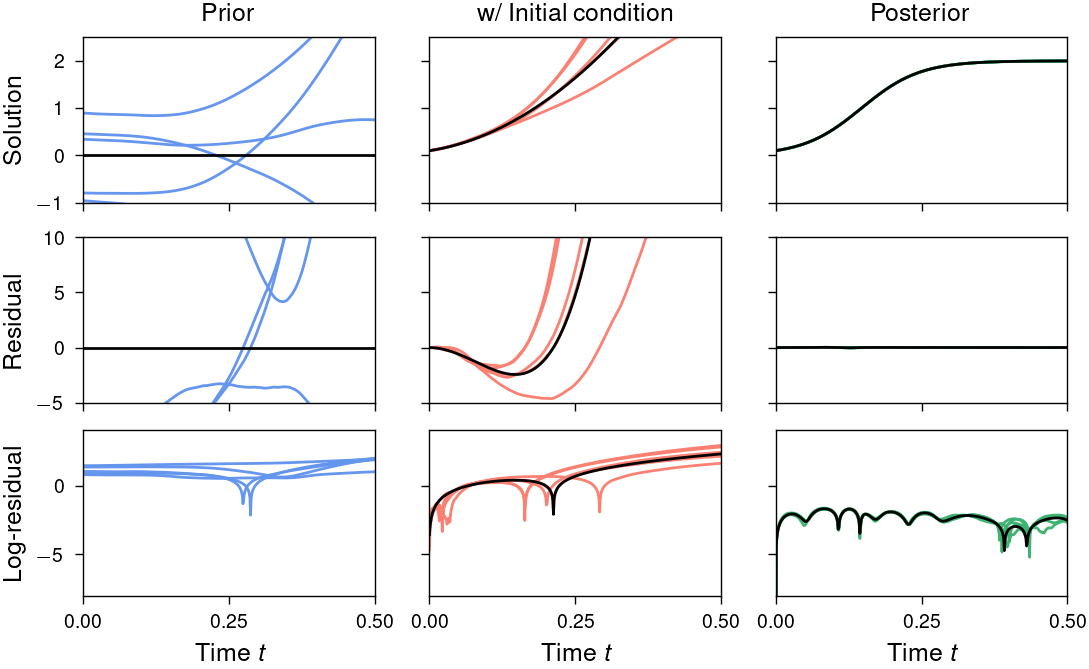

In [12]:
fig, (axes, axes_magnitude, axes_log) = plt.subplots(
    nrows=3, ncols=3, sharex=True, sharey="row", constrained_layout=True
)
axes[0].set_title("Prior")
axes[1].set_title("w/ Initial condition")
axes[2].set_title("Posterior")

style = {"marker": "None", "alpha": 0.99}


def log_residual(*args):
    return jnp.log10(jnp.abs(residual(*args)))


def residual(x, t):
    return x[..., 1] - jax.vmap(vector_field)(x[..., 0], t)


for i in range(num_samples):
    axes[0].plot(ts[1:], samples_prior[i, ..., 0], **style, color="C0")
    axes[1].plot(ts[1:], samples_tcoeffs[i, ..., 0], **style, color="C1")
    axes[2].plot(ts[:-1], samples_posterior[i, ..., 0], **style, color="C2")

    axes_magnitude[0].plot(
        ts[:-1],
        residual(samples_prior[i, ...], ts[:-1]),
        **style,
        color="C0",
    )
    axes_magnitude[1].plot(
        ts[:-1],
        residual(samples_tcoeffs[i, ...], ts[:-1]),
        **style,
        color="C1",
    )
    axes_magnitude[2].plot(
        ts[:-1],
        residual(samples_posterior[i, ...], ts[:-1]),
        **style,
        color="C2",
    )

    axes_log[0].plot(
        ts[:-1],
        log_residual(samples_prior[i, ...], ts[:-1]),
        **style,
        color="C0",
    )
    axes_log[1].plot(
        ts[:-1],
        log_residual(samples_tcoeffs[i, ...], ts[:-1]),
        **style,
        color="C1",
    )
    axes_log[2].plot(
        ts[:-1],
        log_residual(samples_posterior[i, ...], ts[:-1]),
        **style,
        color="C2",
    )

axes[0].plot(ts[1:], margs_prior.mean[..., 0], color="black", **style)
axes[1].plot(ts[1:], margs_tcoeffs.mean[..., 0], color="black", **style)
axes[2].plot(ts[:-1], margs_posterior.mean[..., 0], color="black", **style)

axes_magnitude[0].plot(
    ts[:-1],
    residual(margs_prior.mean, ts[:-1]),
    **style,
    color="black",
)
axes_magnitude[1].plot(
    ts[:-1],
    residual(margs_tcoeffs.mean, ts[:-1]),
    **style,
    color="black",
)
axes_magnitude[2].plot(
    ts[:-1],
    residual(margs_posterior.mean, ts[:-1]),
    **style,
    color="black",
)


axes_log[0].plot(
    ts[:-1],
    log_residual(margs_prior.mean, ts[:-1]),
    **style,
    color="black",
)
axes_log[1].plot(
    ts[:-1],
    log_residual(margs_tcoeffs.mean, ts[:-1]),
    **style,
    color="black",
)
axes_log[2].plot(
    ts[:-1],
    log_residual(margs_posterior.mean, ts[:-1]),
    **style,
    color="black",
)

axes[0].set_xticks((t0, (t0 + t1) / 2, t1))
axes[0].set_xlim((t0, t1))
axes[0].set_ylim((-1.0, 2.5))
axes_magnitude[0].set_ylim((-5.0, 10))
axes_log[0].set_ylim((-8, 4))

axes[0].set_ylabel("Solution")
axes_magnitude[0].set_ylabel("Residual")
axes_log[0].set_ylabel(r"Log-residual")

axes_log[0].set_xlabel("Time $t$")
axes_log[1].set_xlabel("Time $t$")
axes_log[2].set_xlabel("Time $t$")

fig.align_ylabels()

plt.savefig("collocation_new.pdf", dpi=200)
plt.show()